In [1]:
import requests
import csv
import matplotlib.pyplot as plt
from decimal import Decimal, InvalidOperation  
from bs4 import BeautifulSoup

In [2]:
# Function to scrape table from a given URL and save it as a CSV file
def scrape_to_csv(url, output_filename):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the financial table(s)
    table = soup.find('table')
    rows = table.find_all('tr')

    # Extract header
    header = [th.get_text(strip=True) for th in rows[0].find_all('th')]

    # Extract data rows
    data = []
    for row in rows[1:]:
        row_data = [td.get_text(strip=True) for td in row.find_all('td')]
        # Skip empty rows
        if row_data and any(row_data):  # This checks if the row has any non-empty data
            data.append(row_data)

    # Write data to CSV file (using newline='' to avoid extra blank lines)
    with open(output_filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)  # Writing header
        writer.writerows(data)  # Writing data rows

    print(f"Data from {url} saved to {output_filename}")

In [3]:
# URLs to scrape financial data
title = input("What is the company's ticker: ")
income_statement_url = f'https://stockanalysis.com/stocks/{title.lower()}/financials/'
balance_sheet_url = f'https://stockanalysis.com/stocks/{title.lower()}/financials/balance-sheet/'

# File names for storing scraped data
income_statement_csv = f'{title}_is_annual.csv'
balance_sheet_csv = f'{title}_asset_annual.csv'

# Scrape both URLs and save to CSV
scrape_to_csv(income_statement_url, income_statement_csv)
scrape_to_csv(balance_sheet_url, balance_sheet_csv)

What is the company's ticker:  NFLX


Data from https://stockanalysis.com/stocks/nflx/financials/ saved to NFLX_is_annual.csv
Data from https://stockanalysis.com/stocks/nflx/financials/balance-sheet/ saved to NFLX_asset_annual.csv


In [4]:
# Reading net income from 'AAPL_is_annual.csv'
with open(income_statement_csv, mode='r') as file:
    csvFile = csv.reader(file)
    header = next(csvFile)
    net_income = None
    for lines in csvFile:
        if lines[0].strip() == "Net Income":
            net_income = lines[:1:-1]  # Extract Net Income values
    if net_income is None:
        raise ValueError("Net Income data not found in the file.")
    header_title = header[:1:-1]  # Extract years/titles
    print("Header (Years):", header_title)
    print("Net Income:", net_income)

# Reading stockholders' equity from 'AAPL_asset_annual.csv'
with open(balance_sheet_csv, mode='r') as file:
    csvFile = csv.reader(file)
    stockholders_equity = None
    for lines in csvFile:
        if lines[0].strip() == "Shareholders' Equity":
            stockholders_equity = lines[:1:-1]  # Extract Stockholders' Equity values
    if stockholders_equity is None:
        raise ValueError("Stockholders' Equity data not found in the file.")
    print("Stockholders' Equity:", stockholders_equity)

# Check the lengths of both lists
print("Length of Net Income:", len(net_income))
print("Length of Stockholders' Equity:", len(stockholders_equity))

Header (Years): ['2018 - 2014', 'FY 2019', 'FY 2020', 'FY 2021', 'FY 2022', 'FY 2023']
Net Income: ['Upgrade', '1,867', '2,761', '5,116', '4,492', '5,408']
Stockholders' Equity: ['Upgrade', '7,582', '11,065', '15,849', '20,777', '20,588']
Length of Net Income: 6
Length of Stockholders' Equity: 6


In [5]:
# Ensure that the data for net_income and stockholders_equity have the same length
min_length = min(len(net_income), len(stockholders_equity))
if len(net_income) != len(stockholders_equity):
    print(
        f"Warning: Net Income and Stockholders' Equity data have different lengths. Using the first {min_length} elements for both.")

In [6]:
# Perform DuPont analysis
dupont_analysis = []
for x in range(min_length):
    try:
        # Clean and convert strings to Decimal for calculation
        ni = net_income[x].replace(',', '').replace('(', '-').replace(')', '')  # Handle commas and negative numbers
        se = stockholders_equity[x].replace(',', '').replace('(', '-').replace(')', '')
        
        # Convert to Decimal and calculate DuPont ratio
        result = Decimal(ni) / Decimal(se)
        dupont_analysis.append(result)
    except InvalidOperation as e:
        print(f"Invalid data at index {x}: Net Income = {net_income[x]}, Stockholders' Equity = {stockholders_equity[x]}")
        dupont_analysis.append(None)  # Append None if conversion fails

Invalid data at index 0: Net Income = Upgrade, Stockholders' Equity = Upgrade


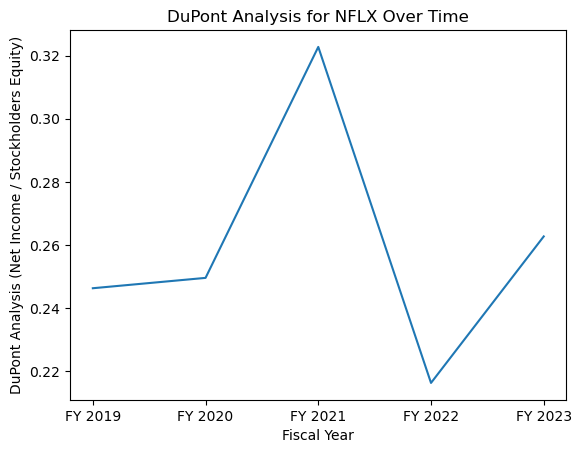

In [7]:
# Plot the DuPont analysis over the fiscal years (trim header_title to match min_length)
plt.plot(header_title[:min_length], dupont_analysis)
plt.xlabel('Fiscal Year')
plt.ylabel('DuPont Analysis (Net Income / Stockholders Equity)')
plt.title(f'DuPont Analysis for {title} Over Time')
plt.show()